In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 1. Load Datasets

In [2]:
df = pd.read_csv('../data_mongo_mapreduce/daily_tweets.csv', index_col=0).sort_index()
df.sample(5)

,count_pos_tweets,count_neg_tweets,ratio_pos_tweets,average_lenContent,average_replyCount,average_retweetCount,average_likeCount,average_quoteCount,average_followerCount,average_friendCount,...,average_neu,average_neg,average_compound,count_all,count_hasLinks,count_hasMedia,count_isRetweeted,count_isQuoted,count_hasHashtags,count_verified
2022-08-15,105.0,151.0,0.410156,204.914062,0.496094,1.753906,9.703125,0.101562,35390.867188,2024.281250,...,0.772086,0.109609,0.022883,256.0,129.0,67.0,0.0,29.0,200.0,0.0
2022-01-02,96.0,160.0,0.375000,191.093750,2.121094,12.316406,43.410156,0.734375,57678.867188,2858.953125,...,0.746793,0.126469,-0.013769,256.0,82.0,48.0,0.0,42.0,186.0,0.0
2020-11-03,102.0,154.0,0.398438,197.875000,0.562500,1.261719,3.890625,0.144531,19918.011719,2064.570312,...,0.777855,0.102672,0.029595,256.0,117.0,69.0,0.0,34.0,206.0,0.0
2021-02-17,112.0,144.0,0.437500,197.960938,0.550781,1.304688,5.316406,0.164062,11125.179688,2475.863281,...,0.764121,0.110617,0.045951,256.0,145.0,94.0,0.0,21.0,206.0,0.0
2021-02-14,108.0,148.0,0.421875,195.351562,0.636719,1.125000,5.003906,0.085938,15699.390625,2855.195312,...,0.779113,0.095437,0.047733,256.0,118.0,66.0,0.0,36.0,188.0,0.0


In [3]:
# Downloaded from https://ourworldindata.org/explorers/coronavirus-data-explorer
df_covid = pd.read_csv('owid-covid-data.csv', index_col=0).sort_index()
df_covid.sample(5)

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
iso_code,,,,,,,,,,,,,,,,,,,,,
ABW,North America,Aruba,2020-12-19,5124.0,18.0,16.143,47.0,0.0,0.143,48131.205,...,NaN,NaN,NaN,76.29,NaN,106459.0,NaN,NaN,NaN,NaN
COG,Africa,Congo,2023-01-25,25069.0,0.0,0.286,388.0,0.0,0.000,4198.860,...,52.3,47.964,NaN,64.57,0.574,5970430.0,NaN,NaN,NaN,NaN
MUS,Africa,Mauritius,2022-09-05,259730.0,138.0,204.143,1024.0,1.0,0.143,199872.564,...,40.7,NaN,3.4,74.99,0.804,1299478.0,NaN,NaN,NaN,NaN
VGB,North America,British Virgin Islands,2023-04-28,7305.0,0.0,0.000,64.0,0.0,0.000,233148.219,...,NaN,NaN,NaN,79.07,NaN,31332.0,NaN,NaN,NaN,NaN
SWZ,Africa,Eswatini,2020-05-30,283.0,4.0,8.286,2.0,0.0,0.000,235.504,...,16.5,24.097,2.1,60.19,0.611,1201680.0,NaN,NaN,NaN,NaN


### 2. Check Dataset

In [4]:
date_range = list(sorted(df.index))
print('Tweet Data date range is from %s to %s' % (date_range[0], date_range[-1]))

date_range_covid = list(sorted(df_covid['date'].unique()))
print('Covid Data date range is from %s to %s' % (date_range_covid[0], date_range_covid[-1]))

Tweet Data date range is from 2020-02-11 to 2023-05-24
Covid Data date range is from 2020-01-01 to 2023-05-26


In [5]:
# Shows number of Nans, dtypes and the shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199 entries, 2020-02-11 to 2023-05-24
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   count_pos_tweets       1199 non-null   float64
 1   count_neg_tweets       1199 non-null   float64
 2   ratio_pos_tweets       1199 non-null   float64
 3   average_lenContent     1199 non-null   float64
 4   average_replyCount     1199 non-null   float64
 5   average_retweetCount   1199 non-null   float64
 6   average_likeCount      1199 non-null   float64
 7   average_quoteCount     1199 non-null   float64
 8   average_followerCount  1199 non-null   float64
 9   average_friendCount    1199 non-null   float64
 10  average_pos            1199 non-null   float64
 11  average_neu            1199 non-null   float64
 12  average_neg            1199 non-null   float64
 13  average_compound       1199 non-null   float64
 14  count_all              1199 non-null   float64

In [6]:
# Shows number of Nans, dtypes and the shape
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313167 entries, ABW to ZWE
Data columns (total 66 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   continent                                   298293 non-null  object 
 1   location                                    313167 non-null  object 
 2   date                                        313167 non-null  object 
 3   total_cases                                 277045 non-null  float64
 4   new_cases                                   304385 non-null  float64
 5   new_cases_smoothed                          303121 non-null  float64
 6   total_deaths                                256295 non-null  float64
 7   new_deaths                                  304452 non-null  float64
 8   new_deaths_smoothed                         303222 non-null  float64
 9   total_cases_per_million                     277045 non-null  float64
 10  ne

In [7]:
# Get Only World covid data
df_covid_world = df_covid[df_covid['location'] == 'World']
world_covid_data = df_covid_world[['new_cases', 'new_deaths', 'total_cases', 'total_deaths']]
world_covid_data.index = df_covid_world['date']
world_covid_data = world_covid_data.sort_index()
world_covid_data.sample(5)

,new_cases,new_deaths,total_cases,total_deaths
date,,,,
2023-01-01,1993492.0,5137.0,734835830.0,6721426.0
2021-10-18,336756.0,5567.0,241222390.0,4950184.0
2020-07-10,227723.0,5924.0,12281007.0,619901.0
2020-07-12,236378.0,5822.0,12740645.0,631835.0
2021-12-09,701857.0,8163.0,268120503.0,5330350.0


In [8]:
# Filter the dates
world_covid_data = world_covid_data.loc[df.index,:]
world_covid_data

,new_cases,new_deaths,total_cases,total_deaths
2020-02-11,2484.0,100.0,43015.0,1115.0
2020-02-12,2035.0,5.0,45050.0,1120.0
2020-02-13,15170.0,253.0,60220.0,1373.0
2020-02-14,4071.0,152.0,64291.0,1525.0
2020-02-15,2662.0,144.0,66950.0,1669.0
...,...,...,...,...
2023-05-20,33567.0,172.0,766758430.0,6934951.0
2023-05-21,85783.0,576.0,766844213.0,6935527.0
2023-05-22,45769.0,310.0,766889982.0,6935837.0
2023-05-23,4329.0,39.0,766894311.0,6935876.0


In [9]:
# Shows number of Nans, dtypes and the shape
world_covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199 entries, 2020-02-11 to 2023-05-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   new_cases     1199 non-null   float64
 1   new_deaths    1199 non-null   float64
 2   total_cases   1199 non-null   float64
 3   total_deaths  1199 non-null   float64
dtypes: float64(4)
memory usage: 46.8+ KB


### 3. Visualize Dataset

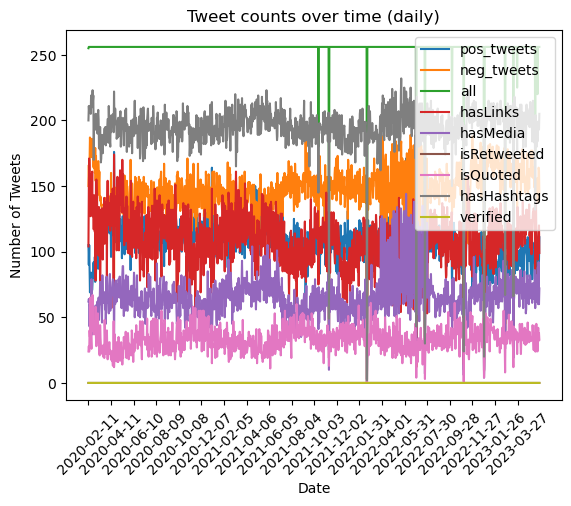

In [10]:
# Show tweet counts over time for count fields
for field in df.columns:
    if field.startswith('count_'):
        plt.plot(df[field], label=field.replace('count_', ''))
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Tweet counts over time (daily)')
plt.show()

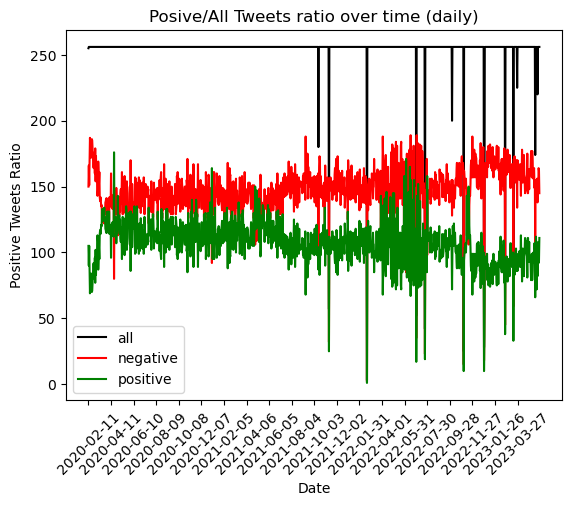

In [11]:
# Show number of positive and negative tweets over time
plt.plot(df['count_all'], color='black', label='all')
plt.plot(df['count_neg_tweets'], color='red', label='negative')
plt.plot(df['count_pos_tweets'], color='green', label='positive')
plt.ylabel('Positive Tweets Ratio')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Posive/All Tweets ratio over time (daily)')
plt.show()

C:\Users\Serra\anaconda3new\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


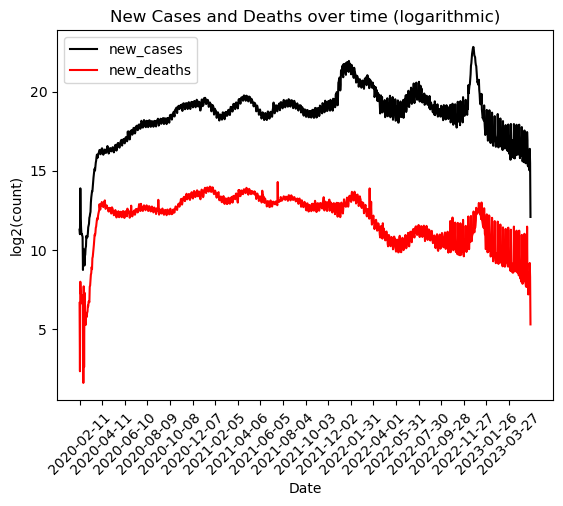

In [12]:
# Show number of new cases and deaths over time
log_new_cases = np.log2(world_covid_data['new_cases'])
log_new_deaths = np.log2(world_covid_data['new_deaths'])
plt.plot(log_new_cases, color='black', label='new_cases')
plt.plot(log_new_deaths, color='red', label='new_deaths')
plt.ylabel('log2(count)')
plt.xlabel('Date')
plt.xticks(list(world_covid_data.index)[::60], rotation=45)
plt.legend()
plt.title('New Cases and Deaths over time (logarithmic)')
plt.show()

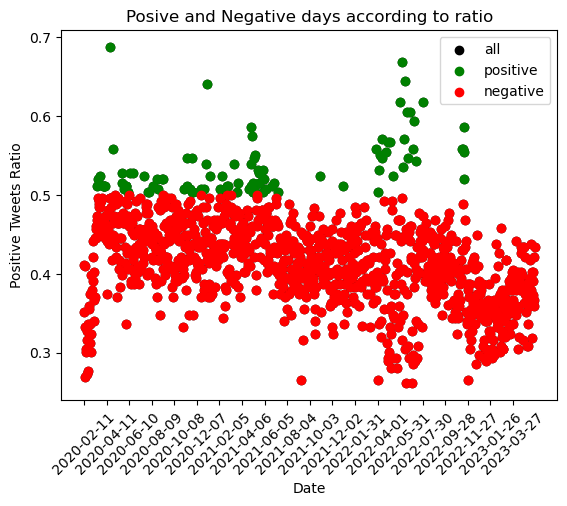

In [13]:
# Positive and Negatives days over time
ratio_pos_tweets = df['ratio_pos_tweets']
mostly_positive = ratio_pos_tweets[ratio_pos_tweets>0.5]
mostly_negative = ratio_pos_tweets[ratio_pos_tweets<=0.5]
plt.scatter(ratio_pos_tweets.index, ratio_pos_tweets, color='black', label='all')
plt.scatter(mostly_positive.index, mostly_positive, color='green', label='positive')
plt.scatter(mostly_negative.index, mostly_negative, color='red', label='negative')
plt.ylabel('Positive Tweets Ratio')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Posive and Negative days according to ratio')
plt.show()

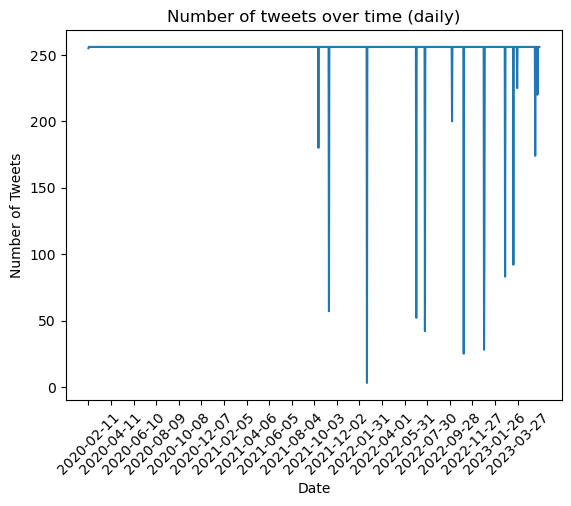

In [14]:
# Show number of tweets over time
plt.plot(df['count_all'])
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.title('Number of tweets over time (daily)')
plt.show()

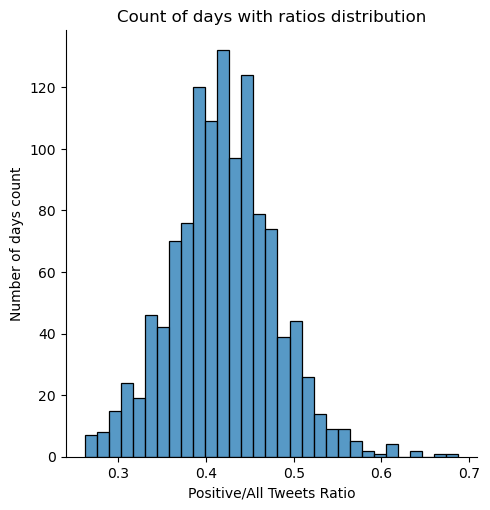

In [15]:
# Count of days with ratios distribution
grid = sns.displot(data=df, x='ratio_pos_tweets')
grid.set(xlabel='Positive/All Tweets Ratio', ylabel='Number of days count')
grid.set(title='Count of days with ratios distribution')

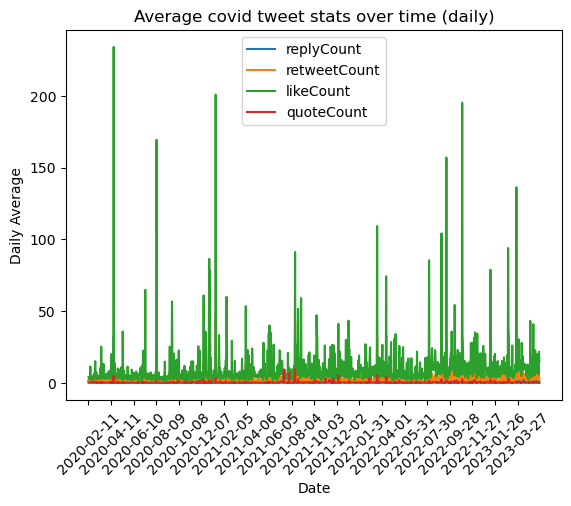

In [16]:
# Show average covid tweet stats over time
tweet_fields = ['replyCount', 'retweetCount', 'likeCount', 'quoteCount']
for field in tweet_fields:
    plt.plot(df['average_%s' % field], label=field)
plt.ylabel('Daily Average')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Average covid tweet stats over time (daily)')
plt.show()

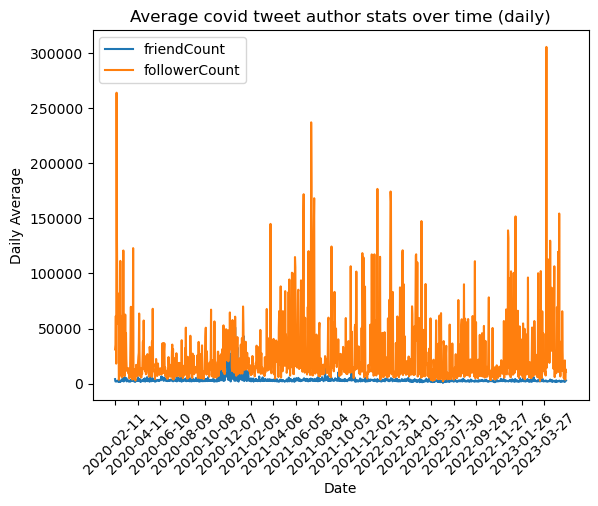

In [17]:
# Show average covid tweet author user stats over time
tweet_fields = ['friendCount', 'followerCount']
for field in tweet_fields:
    plt.plot(df['average_%s' % field], label=field)
plt.ylabel('Daily Average')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Average covid tweet author stats over time (daily)')
plt.show()

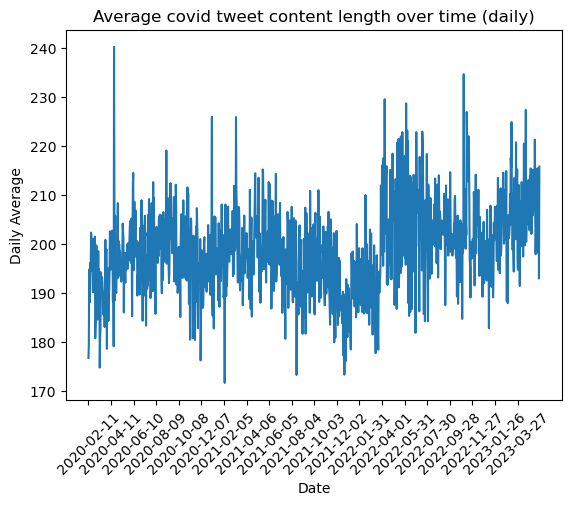

In [18]:
# Show average covid tweet stats over time
plt.plot(df['average_lenContent'])
plt.ylabel('Daily Average')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.title('Average covid tweet content length over time (daily)')
plt.show()

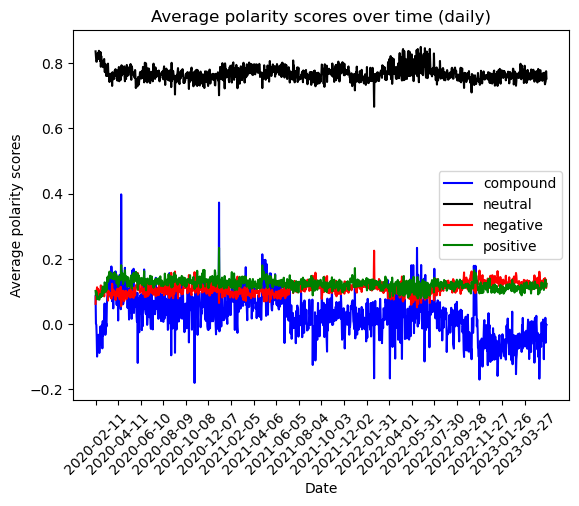

In [19]:
# Show tweet counts over time for count fields
plt.plot(df['average_compound'], color='blue', label='compound')
plt.plot(df['average_neu'], color='black', label='neutral')
plt.plot(df['average_neg'], color='red', label='negative')
plt.plot(df['average_pos'], color='green', label='positive')
plt.ylabel('Average polarity scores')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Average polarity scores over time (daily)')
plt.show()

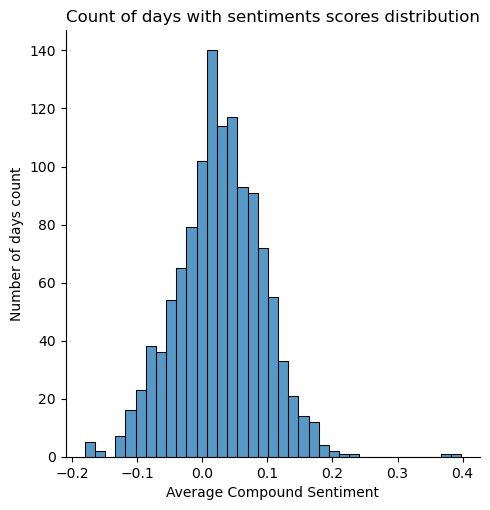

In [20]:
# Count of days with compound distribution
grid = sns.displot(data=df, x='average_compound')
grid.set(xlabel='Average Compound Sentiment', ylabel='Number of days count')
grid.set(title='Count of days with sentiments scores distribution')

In [21]:
# Create mixed data for visualization
mixed_df = pd.DataFrame({
    'new_cases': world_covid_data['new_cases'],
    'new_deaths': world_covid_data['new_deaths'],
    'log_new_cases': np.log2(world_covid_data['new_cases']),
    'log_new_deaths': np.log2(world_covid_data['new_deaths']),
    'count_neg_tweets': df['count_neg_tweets'],
    'count_pos_tweets': df['count_pos_tweets'],
    'ratio_pos_tweets': df['ratio_pos_tweets'],
    'sentiment_compound': df['average_compound'],
    'sentiment_neutral': df['average_neu'],
    'sentiment_negative': df['average_neg'],
    'sentiment_positive': df['average_pos'],
    'average_lenContent': df['average_lenContent'],
})
mixed_df.sample(5)

C:\Users\Serra\anaconda3new\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,new_cases,new_deaths,log_new_cases,log_new_deaths,count_neg_tweets,count_pos_tweets,ratio_pos_tweets,sentiment_compound,sentiment_neutral,sentiment_negative,sentiment_positive,average_lenContent
2021-11-15,414894.0,6349.0,18.662383,12.632314,157.0,99.0,0.386719,0.017102,0.782957,0.103949,0.113094,193.125000
2021-12-24,1007757.0,7314.0,19.942716,12.836445,140.0,116.0,0.453125,0.064246,0.729543,0.119957,0.150504,185.605469
2020-06-29,178684.0,5007.0,17.447051,12.289731,130.0,126.0,0.492188,0.096253,0.784117,0.085910,0.129961,198.375000
2020-11-30,523787.0,9119.0,18.998621,13.154660,148.0,108.0,0.421875,0.009766,0.742238,0.128391,0.129383,196.093750
2021-08-02,532230.0,9039.0,19.021690,13.141947,142.0,114.0,0.445312,0.047201,0.771633,0.107500,0.120863,202.671875


<Axes: >

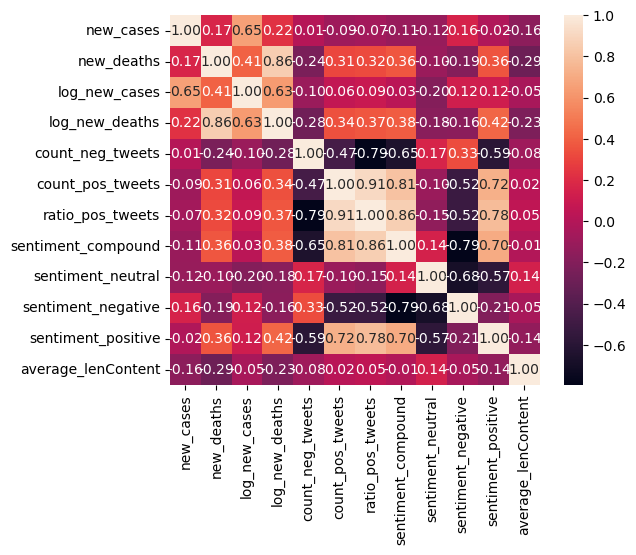

In [22]:
# Correlation of mixed data columns
sns.heatmap(mixed_df.corr(), cbar=True, annot=True, square=True, fmt='.2f')

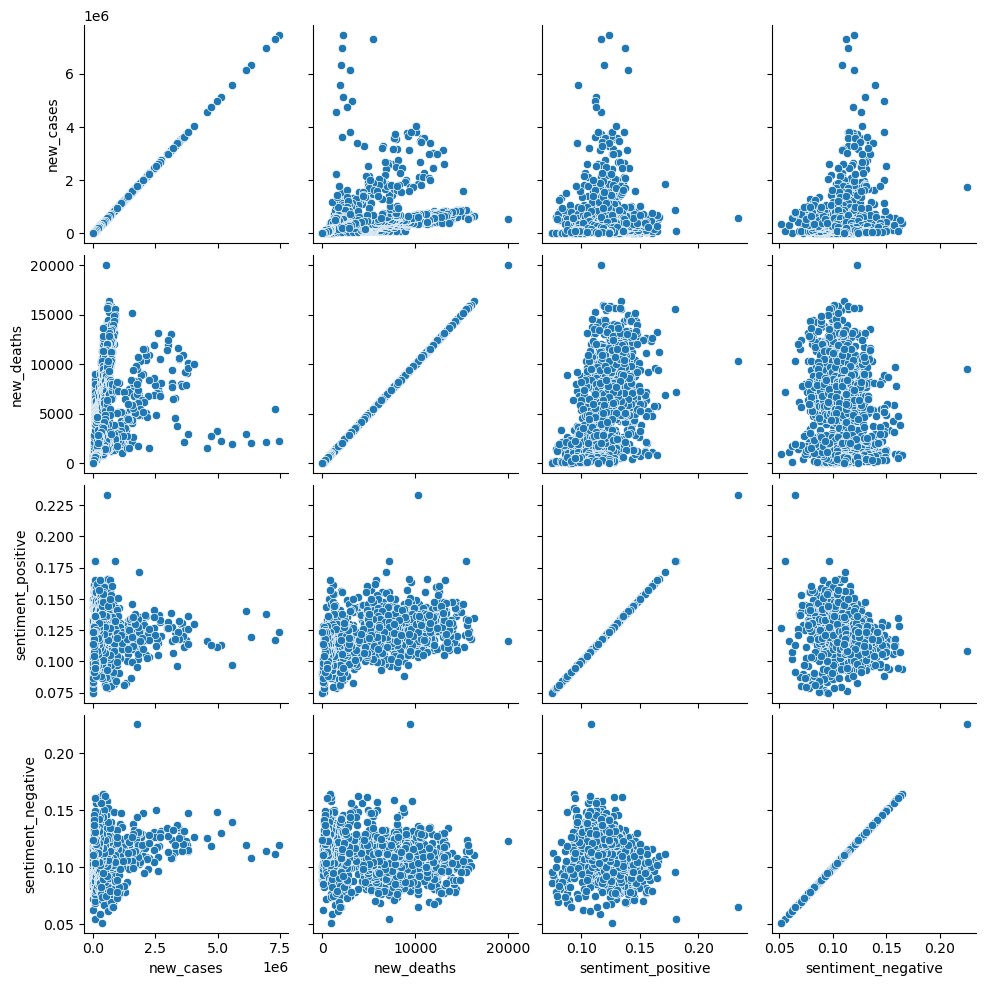

In [23]:
# Pair-wise comparison on some columns
comp_columns = ['new_cases', 'new_deaths', 'sentiment_positive', 'sentiment_negative']
sns.pairplot(mixed_df[comp_columns], diag_kind=None)

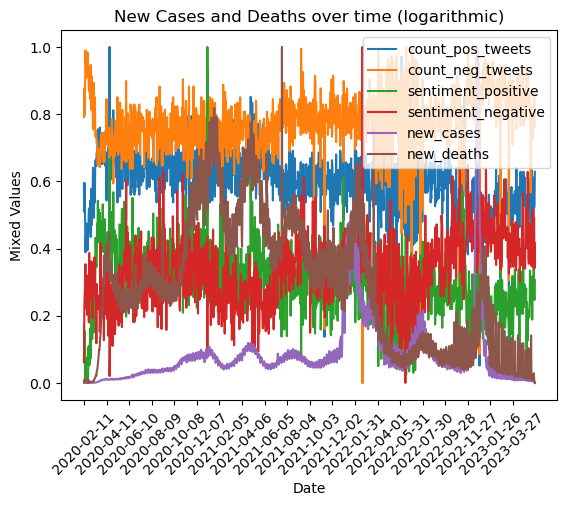

In [24]:
# Compare MinMax scaled fields
fields = ['count_pos_tweets', 'count_neg_tweets', 'sentiment_positive', 'sentiment_negative', 'new_cases', 'new_deaths']
# Keep scaled fields
minmax_dict = {}
for f in fields:
    minmax_field = MinMaxScaler().fit_transform(mixed_df[[f]])
    minmax_field = pd.DataFrame(minmax_field, index=mixed_df.index)
    minmax_dict[f] = minmax_field[0]
    plt.plot(minmax_field, label=f)

plt.ylabel('Mixed Values')
plt.xlabel('Date')
plt.xticks(list(world_covid_data.index)[::60], rotation=45)
plt.legend()
plt.title('New Cases and Deaths over time (logarithmic)')
plt.show()

<Axes: >

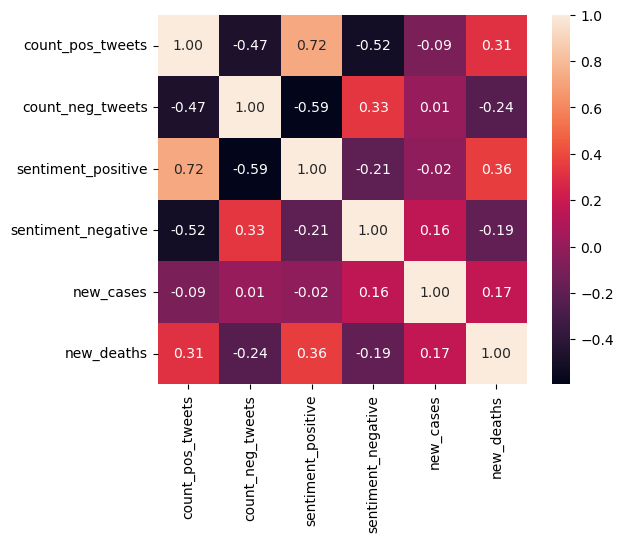

In [25]:
# Correlation of MinMax scaled columns
sns.heatmap(pd.DataFrame(minmax_dict, index=mixed_df.index).corr(), cbar=True, annot=True, square=True, fmt='.2f')

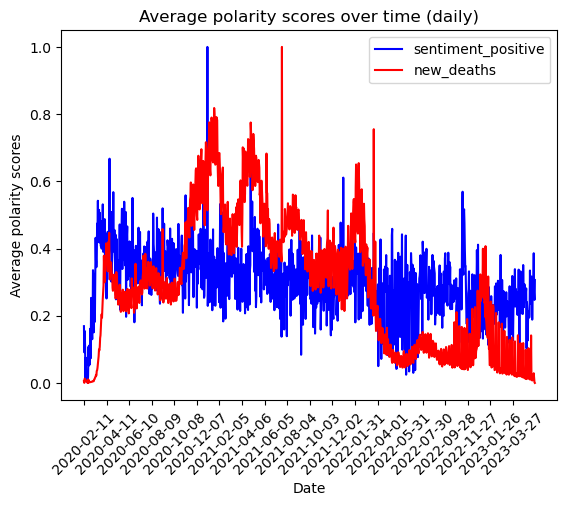

In [26]:
# Compare MinMax scaled new_deaths and sentiment_positive (with +0.36 correlation)
plt.plot(minmax_dict['sentiment_positive'], color='blue', label='sentiment_positive')
plt.plot(minmax_dict['new_deaths'], color='red', label='new_deaths')
plt.ylabel('Average polarity scores')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Average polarity scores over time (daily)')
plt.show()

### 4. Check Time Series

In [27]:
# Create time series data frame for compound sentiment
# Scale [-1,1] compound polarity scores to [0,1]
#   Unsclaed -1 and scaled 0 are negative
#   Unscaled 0 and scaled 0.5 are neutral
#   Unscaled 1 and scaled 1 are positive
ts = (1 + df['average_compound']) / 2
ts.describe()

count    1199.000000
mean        0.513726
std         0.032860
min         0.409781
25%         0.493581
50%         0.513848
75%         0.535521
max         0.698853
Name: average_compound, dtype: float64

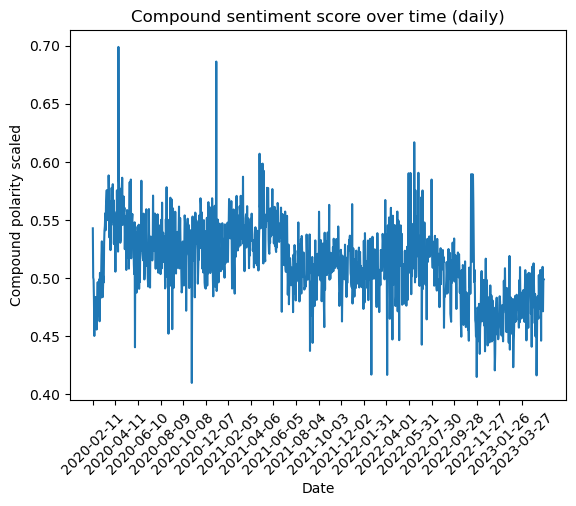

In [28]:
# Plot scaled time series
plt.plot(ts)
plt.ylabel('Compound polarity scaled')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.title('Compound sentiment score over time (daily)')
plt.show()

In [42]:
def plot_decomposition(decomposition_model, decomposition_period):
    decomposition = seasonal_decompose(ts, model=decomposition_model, period=decomposition_period)

    fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(8, 8), layout='constrained', sharex=True)
    fig.suptitle('Seasonal %s Decomposition (period = %d)' % (decomposition_model, decomposition_period))

    ax1 = sns.lineplot(decomposition.observed, ax=axs[0])
    ax1.set_ylabel('Observed')

    ax2 = sns.lineplot(decomposition.observed/decomposition.seasonal, ax=axs[1])
    ax2.set_ylabel('Deseasonalized')

    ax3 = sns.lineplot(decomposition.observed/decomposition.resid, ax=axs[2])
    ax3.set_ylabel('Deleted Residuals')

    ax4 = sns.lineplot(decomposition.trend, ax=axs[3])
    ax4.set_ylabel('Trend')

    plt.xlabel('Date')
    plt.xticks(list(ts.index)[::60], rotation=45)
    plt.show()

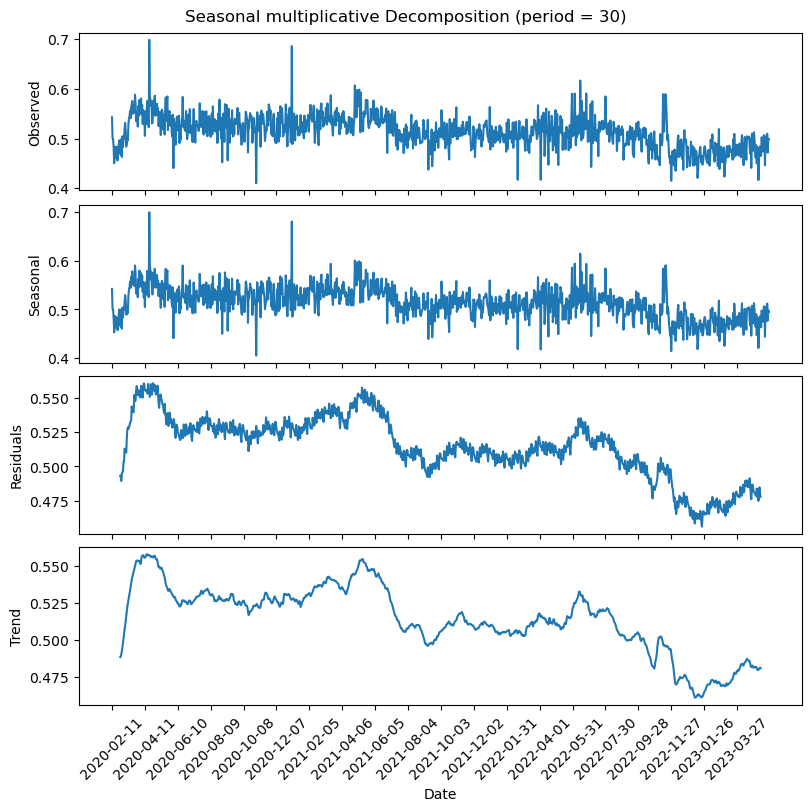

In [41]:
# Multiplicative Seasonal Decomposition for a month period
plot_decomposition('multiplicative', 30)

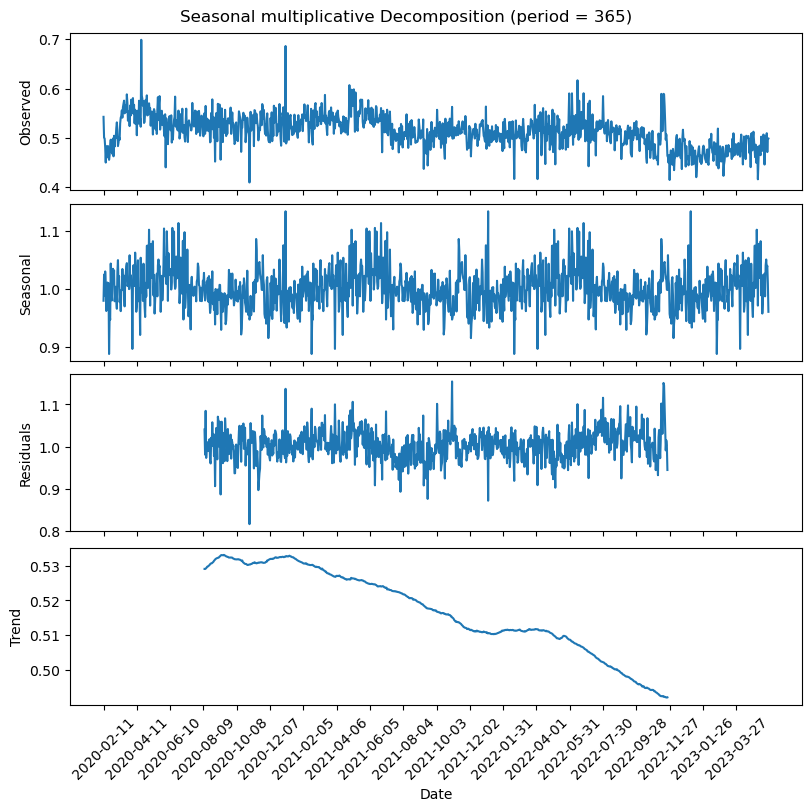

In [31]:
# Multiplicative Seasonal Decomposition for a year period
plot_decomposition('multiplicative', 365)

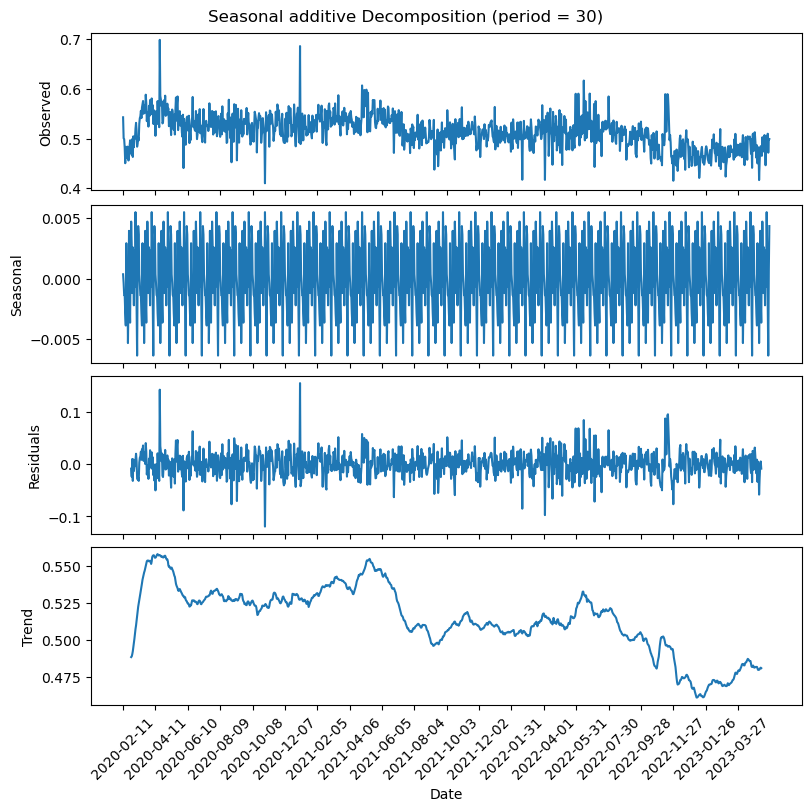

In [32]:
# Additive Seasonal Decomposition for a month period
plot_decomposition('additive', 30)

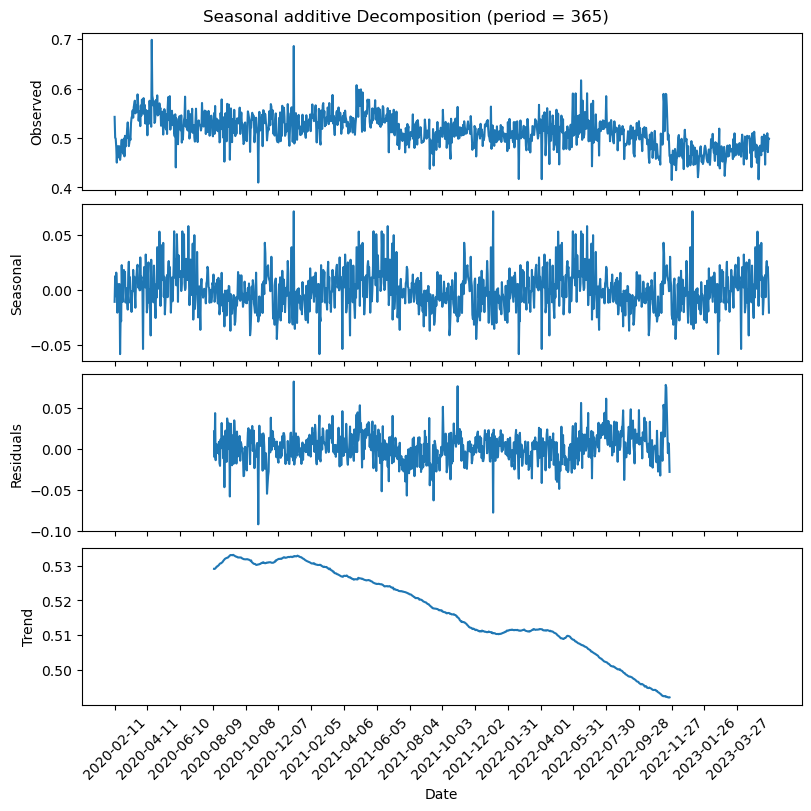

In [33]:
# Additive Seasonal Decomposition for a year period
plot_decomposition('additive', 365)

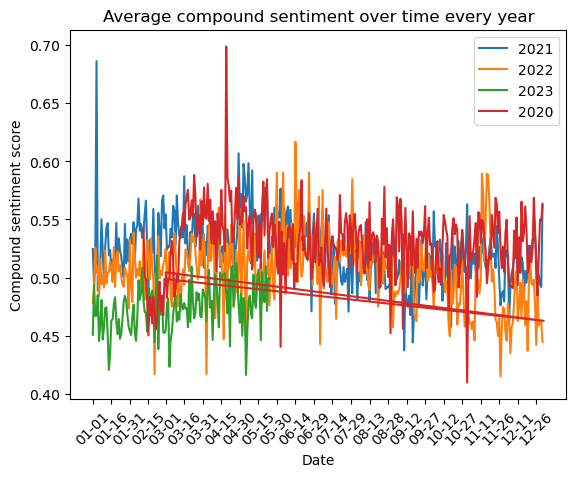

In [34]:
# Plot years with shared month x axis
temp_df = ts.reset_index()
temp_df['Year'] = temp_df['index'].apply(lambda d: d.split('-')[0])
temp_df['YearlessDate'] = temp_df['index'].apply(lambda d: d[5:])

for y in ['2021', '2022', '2023', '2020']:
    temp_year = temp_df[temp_df['Year'] == y]
    temp_year.index = temp_year['YearlessDate']
    temp_year = temp_year.sort_index()
    plt.plot(temp_year['average_compound'], label=y)

plt.ylabel('Compound sentiment score')
plt.xlabel('Date')
plt.legend()
plt.xticks(list(sorted(temp_df['YearlessDate'].unique()))[::15], rotation=45)
plt.title('Average compound sentiment over time every year')
plt.show()

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


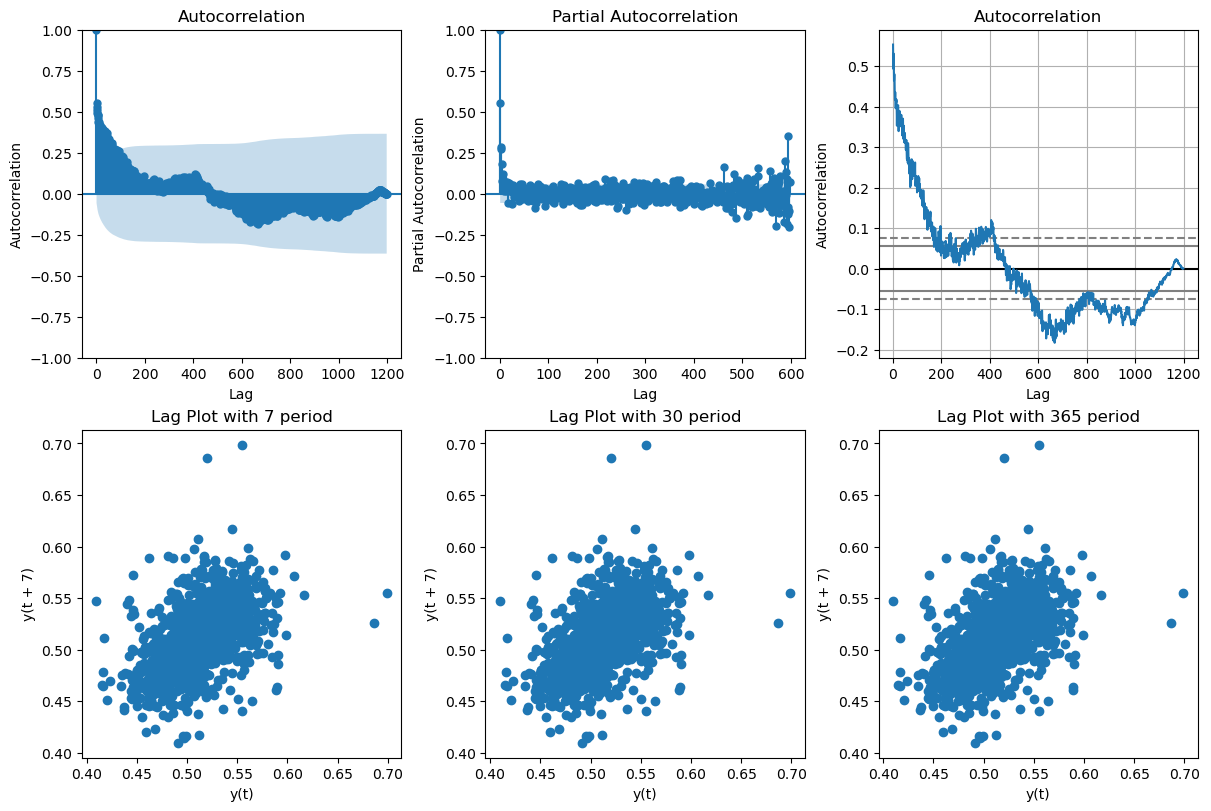

In [35]:
# Lagged correlation over time 
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 8), layout='constrained')

plot_acf(ts, lags=ts.shape[0]-1, ax=axs[0,0])
axs[0,0].set_title('Autocorrelation')
axs[0,0].set_ylabel('Autocorrelation')
axs[0,0].set_xlabel('Lag')

plot_pacf(ts, lags=ts.shape[0]//2-1, ax=axs[0,1])
axs[0,1].set_title('Partial Autocorrelation')
axs[0,1].set_ylabel('Partial Autocorrelation')
axs[0,1].set_xlabel('Lag')

autocorrelation_plot(ts, ax=axs[0,2])
axs[0,2].set_title('Autocorrelation')

for i, l in enumerate([7, 30, 365]):
    lag_plot(ts, lag=7, ax=axs[1,i])
    axs[1,i].set_title('Lag Plot with %d period' % l)

plt.show()


In [36]:
# Autoregressive model using Conditional Maximum Likelihood (OLS).
ar_model = AutoReg(ts, 1).fit()
ar_model.summary()

C:\Users\Serra\anaconda3new\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       average_compound   No. Observations:                 1199
Model:                     AutoReg(1)   Log Likelihood                2611.176
Method:               Conditional MLE   S.D. of innovations              0.027
Date:                Sat, 27 May 2023   AIC                          -5216.352
Time:                        19:00:04   BIC                          -5201.086
Sample:                    02-12-2020   HQIC                         -5210.601
                         - 05-24-2023                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2295      0.012     18.532      0.000       0.205       0.254
average_compound.L1     0.5531      0.024     22.988      0.000       0.506       0.600
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8079           +0.0000j            1.8079            0.0000
-----------------------------------------------------------------------------
"""

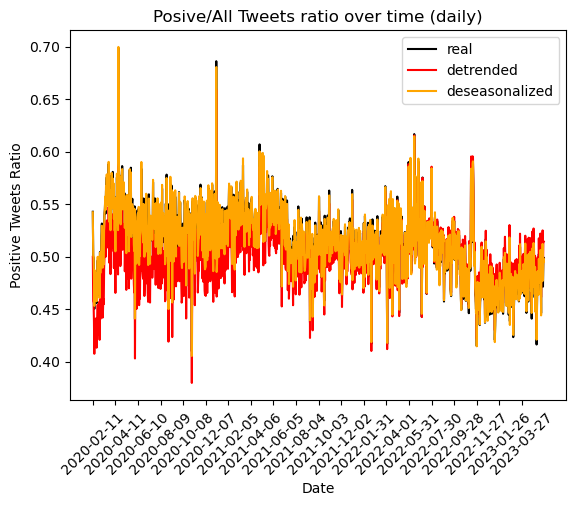

In [37]:
# Compare with detrended and deseasonalized
plt.plot(ts, color='black', label='real')

detrended_ts = 0.5 + signal.detrend(ts.values)
detrended_ts = pd.Series(detrended_ts, index=ts.index)
plt.plot(detrended_ts, color='red', label='detrended')

deseasonalized_ts = ts / seasonal_decompose(ts, model='multiplicative', period=30).seasonal
deseasonalized_ts = pd.Series(deseasonalized_ts, index=ts.index)
plt.plot(deseasonalized_ts, color='orange', label='deseasonalized')

plt.ylabel('Positive Tweets Ratio')
plt.xlabel('Date')
plt.xticks(list(df.index)[::60], rotation=45)
plt.legend()
plt.title('Posive/All Tweets ratio over time (daily)')
plt.show()